In [1]:
import numpy as np
import librosa
import librosa.display as display
import matplotlib.pyplot as plt
import os
import h5py
import time
from IPython.display import Audio
from config import PARAS



MIX_PATH = '../DSD100/Mixtures'
SRC_PATH = '../DSD100/Sources'

# Get File Paths

- Path Dictionary
    - Music File Index
        - Track 1 -> path
        - Track 2 -> path

In [2]:
dev_file_paths = dict()
test_file_paths = dict()

for (dirpath, dirnames, filenames) in os.walk(MIX_PATH):
    if not dirnames:
        if 'Test' in dirpath:
            file_name = dirpath.split('Test/')[-1].split('-')[0].strip()
            test_file_paths[file_name] = dict()
            test_file_paths[file_name]['mix'] = dirpath + '/' + filenames[0]
        elif 'Dev' in dirpath:
            file_name = dirpath.split('Dev/')[-1].split('-')[0].strip()
            dev_file_paths[file_name] = dict()
            dev_file_paths[file_name]['mix'] = dirpath + '/' + filenames[0]

for (dirpath, dirnames, filenames) in os.walk(SRC_PATH):
    if not dirnames:
        if 'Test' in dirpath:
            file_name = dirpath.split('Test/')[-1].split('-')[0].strip()
            for trackname in filenames:
                track = trackname.split('.wav')[0]
                test_file_paths[file_name][track] = dirpath + '/' + trackname
        elif 'Dev' in dirpath:
            file_name = dirpath.split('Dev/')[-1].split('-')[0].strip()
            for trackname in filenames:
                track = trackname.split('.wav')[0]
                dev_file_paths[file_name][track] = dirpath + '/' + trackname
    

# Build Feature Extractor

In [3]:
PARAS.SR, PARAS.N_FFT, PARAS.N_MEL, PARAS.SAMPLE_TIME

(16000, 512, 150, 1)

In [4]:
test_path = dev_file_paths['056']
test_path, len(dev_file_paths)

({'mix': '../DSD100/Mixtures/Dev/056 - Arise - Run Run Run/mixture.wav',
  'vocals': '../DSD100/Sources/Dev/056 - Arise - Run Run Run/vocals.wav',
  'drums': '../DSD100/Sources/Dev/056 - Arise - Run Run Run/drums.wav',
  'other': '../DSD100/Sources/Dev/056 - Arise - Run Run Run/other.wav',
  'bass': '../DSD100/Sources/Dev/056 - Arise - Run Run Run/bass.wav'},
 50)

## The Points
- Do not use the origin mix track, using the sum of vocal and background tracks and return a new mixed track, because the old track is not ensured the normalization
### Remove vocal silence part ( slience is useless for model training)

In [45]:
def remove_silence(vocal, target_track):
    """
    This function remove slience part
    notice it's not an in place dealer
    """
    remove_list = list()
    for i, point in enumerate(vocal):
        if 10**-4 > abs(point): # be careful of the silence part shreshold
            remove_list.append(i)
    vocal_out = np.delete(vocal, remove_list)
    target_track_out = np.delete(target_track, remove_list)
    return vocal_out, target_track_out

### Extract the mix/target signals

In [42]:
def sound_tracks_extractor(file_path):
    """
    Take in a file path dictionary, return:
    (Normalized track)
    vocal track as target
    mixed track as input
    """
    signals = dict()
    for key in file_path:
        if key == 'mix':
            continue
        signals[key], _ = librosa.load(file_path.get(key), sr = PARAS.SR)
        signals[key] = librosa.util.normalize(signals.get(key))
        
    vocal_track = signals.get('vocals')
    return_vocal, _ = remove_silence(vocal_track, vocal_track)
    mix_track = np.zeros(len(return_vocal))

    for key in signals:
        if 'vocals' == key:
            continue
        _, signals[key] = remove_silence(vocal_track, signals.get(key))
        mix_track = signals.get(key) if not len(mix_track) else mix_track + signals.get(key)
    
    mix_track = mix_track + return_vocal
    
    return return_vocal, mix_track

In [43]:
b = sound_tracks_extractor(dev_file_paths['055'])

In [46]:
Audio(b[1], rate=PARAS.SR)

### Generate chunks Spectrogram
#### Create MelConverter

In [151]:
class MelConverter:

    def __init__(self, sample_rate=PARAS.SR, 
                 n_fft=PARAS.N_FFT, 
                 hop_length=PARAS.N_FFT//4, 
                 n_mel_freqs=PARAS.N_MEL,
                 freq_min_hz=0, freq_max_hz=None):
        
        self._SAMPLE_RATE = sample_rate
        self._N_FFT = n_fft
        self._HOP_LENGTH = hop_length
        self._N_MEL_FREQS = n_mel_freqs
        self._FREQ_MIN_HZ = freq_min_hz
        self._FREQ_MAX_HZ = freq_max_hz

        self._MEL_FILTER = librosa.filters.mel(
            sr=self._SAMPLE_RATE,
            n_fft=self._N_FFT,
            n_mels=self._N_MEL_FREQS,
            fmin=self._FREQ_MIN_HZ,
            fmax=self._FREQ_MAX_HZ)

    def signal_to_melspec(self, audio_signal, log=True, get_phase=False, transpose=True):
        D = librosa.core.stft(audio_signal, n_fft=self._N_FFT, hop_length=self._HOP_LENGTH)
        magnitude, phase = librosa.core.magphase(D)
        mel_spectrogram = np.dot(self._MEL_FILTER, magnitude)
        mel_spectrogram = mel_spectrogram ** 2
        
        if log:
            mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        if transpose:
            mel_spectrogram = mel_spectrogram.T
        if get_phase:
            return mel_spectrogram, phase
        else:
            return mel_spectrogram

    def melspec_to_audio(self, mel_spectrogram, log=True, phase=None, transpose=True):
        if transpose:
            mel_spectrogram = mel_spectrogram.T   
        if log:
            mel_spectrogram = librosa.db_to_power(mel_spectrogram)
    
        mel_spectrogram = mel_spectrogram ** 0.5

        magnitude = np.dot(np.linalg.pinv(self._MEL_FILTER), mel_spectrogram)

        if phase is not None:
            inverted_signal = librosa.istft(magnitude * phase, hop_length=self._HOP_LENGTH)
        else:
            inverted_signal = griffin_lim(magnitude, self._N_FFT, self._HOP_LENGTH, n_iterations=10)

        return Audio(inverted_signal, rate=self._SAMPLE_RATE)


def griffin_lim(magnitude, n_fft, hop_length, n_iterations):
    """Iterative algorithm for phase retrival from a magnitude spectrogram."""
    phase_angle = np.pi * np.random.rand(*magnitude.shape)
    D = invert_magnitude_phase(magnitude, phase_angle)
    signal = librosa.istft(D, hop_length=hop_length)

    for i in range(n_iterations):
        D = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
        _, phase = librosa.magphase(D)
        phase_angle = np.angle(phase)

        D = invert_magnitude_phase(magnitude, phase_angle)
        signal = librosa.istft(D, hop_length=hop_length)

    return signal


def invert_magnitude_phase(magnitude, phase_angle):
    phase = np.cos(phase_angle) + 1.j * np.sin(phase_angle)
    return magnitude * phase

In [ ]:
mel_conv = MelConverter()
test_mel = mel_conv.signal_to_melspec(b[0])
mel_conv.melspec_to_audio(test_mel)

In [142]:
# useless, for backup
def signal_divider(signal, sr=PARAS.SR, time=PARAS.SAMPLE_TIME):
    """
    This one takes signal in and devided them in 1s frames
    """
    sample_length = sr * time
    n_frames = len(signal) // sample_length
    new_list = list()
    for i in range(n_frames):
        new_list.append(signal[i*sample_length:(i+1)*sample_length])
    return new_list

#### create mel_spectrogram (150 * 150 frames)

In [149]:
def frame_feature_extractor(signal, mel_converter=mel_conv):
    """
    Takes in new signals and create mel chunks 
    """
#     S = librosa.feature.melspectrogram(y=signal, sr=PARAS.SR, n_mels=PARAS.N_MEL).T
#     S = librosa.power_to_db(S)
    
    S = mel_converter.signal_to_melspec(signal)
    S = S[:-1 * (S.shape[0] % PARAS.N_MEL)] # divide the mel spectrogram
    chunk_num = S.shape[0] // PARAS.N_MEL
    mel_chunks = np.split(S, chunk_num) # create 128 * 128 data frames
    return mel_chunks, chunk_num

In [150]:
vocal_ct, chunk_n = frame_feature_extractor(b[0])
mix_ct, _ = frame_feature_extractor(b[1])

In [50]:
vocal_ct[0].shape, mix_ct[0].shape

((150, 150), (150, 150))

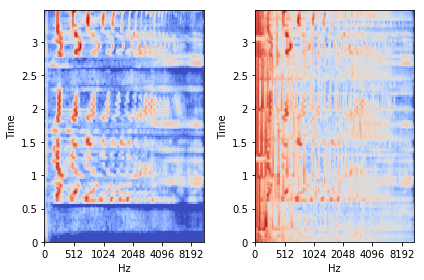

In [54]:
plt.figure()
plt.subplot(1, 2, 1)
librosa.display.specshow(vocal_ct[0], x_axis='mel', y_axis='time')
plt.subplot(1, 2, 2)
librosa.display.specshow(mix_ct[0], x_axis='mel', y_axis='time')
plt.tight_layout()
plt.show()

### Here is a function for reconstruct audio from mel

In [128]:
MEL_FILTER = librosa.filters.mel(sr=PARAS.SR, n_fft=PARAS.N_FFT, n_mels=PARAS.N_MEL)

def griffin_lim(magnitude, n_fft, n_iterations):
    """
    Iterative algorithm for phase retrival from a magnitude spectrogram.
    """
    phase_angle = np.pi * np.random.rand(*magnitude.shape)
    D = invert_magnitude_phase(magnitude, phase_angle)
    
    signal = librosa.istft(D, win_length=n_fft)
    
    for i in range(n_iterations):
        D = librosa.stft(signal, n_fft=n_fft)
        _, phase = librosa.magphase(D)
        phase_angle = np.angle(phase)
        D = invert_magnitude_phase(magnitude, phase_angle)
        signal = librosa.istft(D,win_length=n_fft)
    return signal

def invert_magnitude_phase(magnitude, phase_angle):
    phase = np.cos(phase_angle) + 1.j * np.sin(phase_angle)
    return magnitude * phase

def reconstruct_signal_from_mel_spectrogram(mel_spectrogram, mel_filter=MEL_FILTER, log=True, Trans=True, phase=None):
    if Trans:
        mel_spectrogram = mel_spectrogram.T    
    if log:
        mel_spectrogram = librosa.db_to_power(mel_spectrogram)
        
    mel_spectrogram = mel_spectrogram ** 0.5
    magnitude = np.dot(np.linalg.pinv(mel_filter), mel_spectrogram)
    
    if phase is not None:
        inverted_signal = librosa.istft(magnitude * phase, hop_length=(PARAS.N_FFT//4))
    else:
        inverted_signal = griffin_lim(magnitude, PARAS.N_FFT, n_iterations=10)
    
    return Audio(inverted_signal, rate=PARAS.SR)


In [129]:
S = librosa.feature.melspectrogram(y=b[1], sr=PARAS.SR, n_mels=PARAS.N_MEL).T
S = librosa.power_to_db(S)

In [130]:
reconstruct_signal_from_mel_spectrogram(S)

# Build dataset

In [ ]:
data_set_path = PARAS.DATASET_PATH + 'all.h5'
dataset = h5py.File(data_set_path, 'a')

In [ ]:
len(dev_file_paths), len(test_file_paths), chunk_n

In [ ]:
file_paths = dict(list(dev_file_paths.items())
                  + list(test_file_paths.items()))

## load data
One $ for one file. (100 in total)

In [ ]:
print("start loading data: $", end="")
for key, file_dict in file_paths.items():
    count = 0
    print(file_dict)
    vocal_signal, mix_signal = sound_tracks_extractor(file_dict)
    vocal_chunks, cn = frame_feature_extractor(vocal_signal)
    mix_chunks, _ = frame_feature_extractor(mix_signal)
    
    
    c_setpath = PARAS.DATASET_PATH + '{0}.h5'.format(key)
    c_dataset = h5py.File(c_setpath, 'a')
    
    c_dataset.create_dataset('mix', 
                       shape=(cn, 150, 150), 
                       dtype=np.float32)

    c_dataset.create_dataset('vocal', 
                           shape=(cn, 150, 150), 
                           dtype=np.float32)
    
    for idx in range(cn):
        c_dataset['vocal'][count] = vocal_chunks[idx]
        c_dataset['mix'][count] = mix_chunks[idx]
        count += 1
    
    print("=>${0}".format(key), end="")
    c_dataset.close()

In [ ]:
dataset.create_dataset('mix', 
                       shape=(-1, 150, 150), 
                       dtype=np.float32)

dataset.create_dataset('vocal', 
                       shape=(-1, 150, 150), 
                       dtype=np.float32)